# Use case to create a Reward model, use it and save it

In [1]:
from train_utils import (load_data, prepare_single_dataset)
from model import (RewardModel, RewardModelConfig)
from transformers import RobertaTokenizer
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModel, AutoConfig

c:\Users\antom\miniconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Creating the blank reward model :

In [ ]:
model_name = "smallbenchnlp/roberta-small"

tokenizer = RobertaTokenizer.from_pretrained(model_name)

reward_model_config = RewardModelConfig(lm_base="roberta-base", hidden_dims=[64, 128, 32], activations=["relu", "relu", "relu"])
reward_model = RewardModel(reward_model_config)

### Save the model

In [ ]:
reward_model_config.save_pretrained("models_TEST")
reward_model.save_pretrained("models_TEST")
tokenizer.save_pretrained("models_TEST")

### Use the model

In [ ]:
text = "I am strong"
inp = torch.tensor([tokenizer.encode(text, truncation=True, padding='max_length', max_length=512)])
print("1) RESULT : ", reward_model(inp))

### Load the model

In [ ]:
AutoConfig.register('RewardModel', RewardModelConfig)
AutoModel.register(RewardModelConfig, RewardModel)
tokenizer = AutoTokenizer.from_pretrained("models_TEST")
config = AutoConfig.from_pretrained("models_TEST")
model = AutoModel.from_pretrained("models_TEST", config=config)

In [3]:
load_data("reward_model_v3_1000_neg.json").keys()

dict_keys(['test', 'eval', 'train'])

#### Analyzing results

We produced result using the `train.py` script on GCP and evaluated the model using the `evaluate_model.py` script and we got this : 

- The average value of the differences between $Y^+$ rewards and $Y^-$ rewards:  5.73442497056276
- The std of the differences between $Y^+$ rewards and $Y^-$ rewards:  0.8848593429723259
- Proportion of correct order $Y^+$ and $Y^-$ : 0.9767441860465116

The models was load as follows :

In [ ]:
from train_utils import (prepare_single_dataset, load_data)
from model import (RewardModelConfig, RewardModel)
from transformers import (AutoConfig, AutoModel, AutoTokenizer)


path = "models_hf/checkpoint-1589/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on device : ", device)

AutoConfig.register('RewardModel', RewardModelConfig)
AutoModel.register(RewardModelConfig, RewardModel)
tokenizer = AutoTokenizer.from_pretrained(path)
config = AutoConfig.from_pretrained(path)
model = AutoModel.from_pretrained(path, config=config).to(device)


test_dataset = prepare_single_dataset(load_data("reward_model_v3_1000_neg.json")["test"], tokenizer)

We loaded the dataset annotated with the model `models_hf/checkpoint-1586` and analyze the resuts:

In [2]:

annot = load_data("annotations/res_on_checkpoint-4785.json")
print("number of annaoted test samples : ", len(annot))

metrics = annot[0]
annot = annot[1:]
annot[0]

number of annaoted test samples :  1641


{'y_plus': '<s>[CLS] Would you describe this learning procedure as reinforcement, supervised or unsupervised learning?0) It is supervised, since we explicitely provide the correct weights to initialize the network. 1) It is unsupervised since the network learns implicit associations present in the input without any additional teaching signal. 2) It is reinforcement learning since only weight updates only occur when a pattern is retrieved correctly. [SEP] The question is asking to identify the type of learning procedure based on a given description. \n\nDefinitions:\n- Reinforcement Learning: A type of machine learning where an agent learns to behave in an environment by performing certain actions and receiving rewards or punishments.\n- Supervised Learning: A type of machine learning where the algorithm learns from labeled data, where the correct output is provided for each input.\n- Unsupervised Learning: A type of machine learning where the algorithm learns patterns in data without b

In [3]:
annot_df = pd.DataFrame(annot)
annot_df.head()

,y_plus,y_minus,y_plus_reward,y_minus_reward
0,<s>[CLS] Would you describe this learning proc...,<s>[CLS] Would you describe this learning proc...,1.941388,-4.861646
1,<s>[CLS] Where is hydrogen magnetization measu...,<s>[CLS] Where is hydrogen magnetization measu...,1.915248,-4.856126
2,<s>[CLS] Can there be a race condition in a mu...,<s>[CLS] Can there be a race condition in a mu...,1.936780,-4.861746
3,<s>[CLS] Soient \(V=\mathbb{P}_{6}(\mathbb{R})...,<s>[CLS] Soient \(V=\mathbb{P}_{6}(\mathbb{R})...,1.545948,-4.841226
4,<s>[CLS] You are using a fully-connected neura...,<s>[CLS] You are using a fully-connected neura...,1.931617,-4.863757


In [4]:
def merge_in_one(full_annot):
    df_plus = full_annot[["y_plus", "y_plus_reward"]]
    df_plus.columns = ["y", "reward"]
    df_plus["type"] = "$Y_+$"
    df_minus = full_annot[["y_minus", "y_minus_reward"]]
    df_minus.columns = ["y", "reward"]
    df_minus["type"] = "$Y_-$"
    all_reward = pd.concat([df_plus, df_minus], axis=0).reset_index()
    return all_reward

<ipython-input-4-f2e0e56fe7ee>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plus["type"] = "$Y_+$"
<ipython-input-4-f2e0e56fe7ee>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_minus["type"] = "$Y_-$"


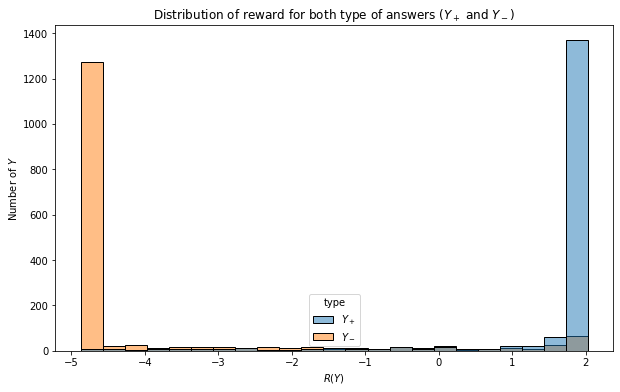

In [5]:
f = plt.figure(figsize=(10, 6))
g = sns.histplot(data=merge_in_one(annot_df), x="reward", hue="type", binwidth=0.3)
# g.set_yscale("log")
g.set_title("Distribution of reward for both type of answers ($Y_+$ and $Y_-$)")
g.set_ylabel("Number of $Y$")
g.set_xlabel("$R(Y)$");

Text(0.5, 0, '$R(R_+) - R(Y_-)$')

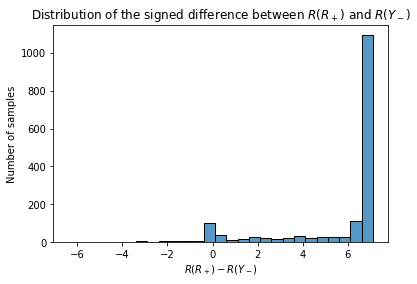

In [6]:
annot_df["diff"] = annot_df["y_plus_reward"] - annot_df["y_minus_reward"]
dg = sns.histplot(data=annot_df, x="diff", binwidth=0.5)
dg.set_title("Distribution of the signed difference between $R(R_+)$ and $R(Y_-)$")
dg.set_ylabel("Number of samples")
dg.set_xlabel("$R(R_+) - R(Y_-)$")